<a href="https://colab.research.google.com/github/we-are-7/EVA6/blob/main/Assignment_Adding_number.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import Libraries

In [41]:
#Import libraries needed for the training in pytorch 
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset
BATCH_SIZE = 64


## 2. Data Loader

In [61]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST(root='./data', download=True, train=True, transform=transform)
valset = datasets.MNIST(root='./data', download=True, train=False, transform=transform)

## 3. Preparing the Network

In [62]:
class MNISTRandCombinedDataset(Dataset):
    def __init__(self, mnist):
        self.mnist = mnist

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        image, label = self.mnist[idx]
        random_number = torch.randint(0, 9, (1,)).item()
        sum_label = label + random_number
        return image, F.one_hot(torch.tensor(random_number), num_classes=10), label, sum_label

In [66]:

trainsetcombination = MNISTRandCombinedDataset(trainset)
traindataloader = torch.utils.data.DataLoader(trainsetcombination,
                                               batch_size=BATCH_SIZE,
                                               shuffle=False,
                                               )
valsetcombination = MNISTRandCombinedDataset(valset)
traindataloader = torch.utils.data.DataLoader(valsetcombination,
                                               batch_size=BATCH_SIZE,
                                               shuffle=False,
                                               )



## 2. Neural Network

In [67]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.out_classes = 10

    self.conv1 = nn.Conv2d(1, 32, 3, padding=2) 
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)   
    self.pool1 = nn.MaxPool2d(2, stride=2)  

    self.conv5 = nn.Conv2d(64, 128, 3, padding=1)  
    self.conv6 = nn.Conv2d(128, 256, 3, padding=1)  
    self.pool2 = nn.MaxPool2d(2, stride=2)

    self.conv7 = nn.Conv2d(256, 512, 3)
    self.conv8 = nn.Conv2d(512, 1024, 3)
    self.conv9 = nn.Conv2d(1024, 10, 3)
    
    self.combined_netw()

  def combined_netw(self):
    self.comL1 = nn.Linear(self.out_classes + 10, 100)
    self.comL2 = nn.Linear(100, 40)
    self.comL3 = nn.Linear(40, 1)

  def forward(self, x1, x2):
    t = x1
    t = self.pool1(F.relu(self.conv2(F.relu( self.conv1(t) ))))
    t = (self.pool2(F.relu(self.conv6(F.relu(self.conv5(t) )))))
    t = self.conv9(F.relu(self.conv8(F.relu( self.conv7(t) ))))

    t = t.view(-1, 10)
    out1 = F.log_softmax(t, dim=1)
    in2 = torch.cat((out1, x2.view(-1, 10)), dim=1)

    out = self.comL3( 
        F.relu(self.comL2( 
        F.relu( self.comL1(in2) ))))
    return out1, out

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = NeuralNetwork().to(device)

In [68]:
def train_network(model, optimizer):
  
  n_train = len(train_set)
  for epoch in range(5):
    totalloss = 0
    totalcorrect1=0
    totalcorrect2=0

    model.train()

    for idx, batch in enumerate(traindataloader):
      x1, x2, target1, target2 = batch
      x1, x2, target1, target2 = x1.to(device), x2.to(device), target1.to(device), target2.to(device)

      optimizer.zero_grad()

      out1, out2 = model(x1, x2)

      loss1 = F.nll_loss(out1, target1)
      loss2 = F.mse_loss(out2.squeeze(1), target2.float())
      loss = 0.2*loss1 + 0.8*loss2

      loss.backward()
      optimizer.step()
      
      totalloss += loss.item()
      totalcorrect1 +=out1.argmax(dim=1).eq(target1).sum().item()
      totalcorrect2 += out2.int().squeeze(1).eq(target2).sum().item()
    print(
        "epoch ", epoch,
        "loss: ",  totalloss/(n_train/BATCH_SIZE), 
        "acc Output1", 100* totalcorrect1/n_train,
        "acc Output2", 100* totalcorrect2/n_train,        
    )

model = NeuralNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_network(model, optimizer)

epoch  0 loss:  2.783161577351888 acc Output1 2.2283333333333335 acc Output2 1.6016666666666666
epoch  1 loss:  1.1535216952006022 acc Output1 6.78 acc Output2 2.308333333333333
epoch  2 loss:  0.4705895374298096 acc Output1 9.048333333333334 acc Output2 4.365
epoch  3 loss:  0.19084629987080892 acc Output1 11.131666666666666 acc Output2 6.858333333333333
epoch  4 loss:  0.13394888264338176 acc Output1 12.423333333333334 acc Output2 7.443333333333333


## experimental code to learn MNIST data

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

torch.set_printoptions(linewidth =120)

In [ ]:
len(train_set)

60000

In [ ]:
len(train_loader)

1875

In [ ]:
train_set.train_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([5, 0, 4,  ..., 5, 6, 8])

In [ ]:
train_set.train_labels.bincount()

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

In [ ]:
sample = next(iter(train_set))
print(len(sample))
print(type(sample))

2
<class 'tuple'>


label: 5


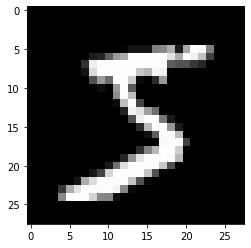

In [ ]:
image,label = sample
plt.imshow(image.squeeze(), cmap ='gray')
print('label:', label)

In [ ]:
batch = next(iter(train_loader))
print(len(batch))
print(type(batch))

2
<class 'list'>


In [ ]:
images ,labels = batch
print(labels.shape)


torch.Size([32])


In [ ]:
print(image.shape)
print(images.shape)

torch.Size([1, 28, 28])
torch.Size([32, 1, 28, 28])


labels: tensor([6, 1, 3, 4, 2, 5, 8, 3, 2, 2, 1, 8, 2, 7, 2, 0, 5, 9, 5, 9, 0, 3, 3, 1, 8, 8, 2, 8, 1, 5, 7, 5])


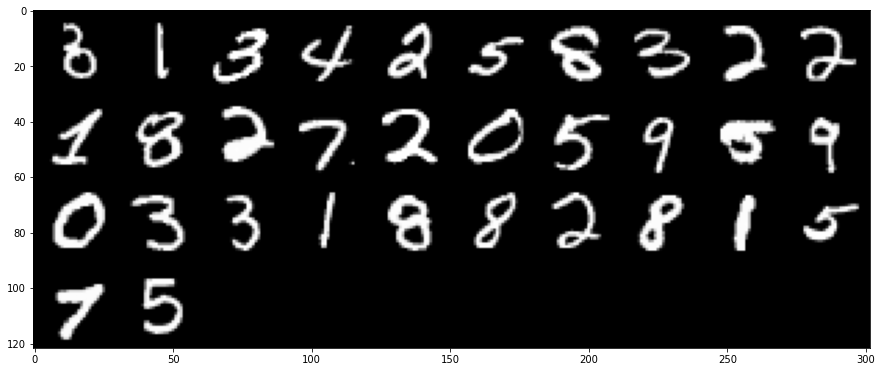

In [ ]:
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print('labels:', labels)

In [ ]:
# Train NN
import torch.nn as nn
import torch.nn.functional as F
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = model().to(device)

TypeError: ignored

In [ ]:
criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss



In [ ]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 10
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(train_loader)))

Epoch 0 - Training loss: 0.6339038550933203
Epoch 1 - Training loss: 0.2599316198607286
Epoch 2 - Training loss: 0.18740446405212086
Epoch 3 - Training loss: 0.14547615432292224
Epoch 4 - Training loss: 0.11764347486570477
Epoch 5 - Training loss: 0.09874676115165154
Epoch 6 - Training loss: 0.08398722166866064
Epoch 7 - Training loss: 0.07321256848300496
Epoch 8 - Training loss: 0.06390584533462922
Epoch 9 - Training loss: 0.05733418859038502


In [ ]:
valset = torchvision.datasets.MNIST(root='./data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [ ]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)

with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
#classify(img.view(1, 28, 28), ps)

Predicted Digit = 5


tensor([[1.0521e-04, 3.7524e-02, 4.0340e-04, 1.2881e-01, 9.9902e-03, 7.8300e-01, 2.1696e-02, 3.4610e-04, 1.1503e-02,
         6.6251e-03]])

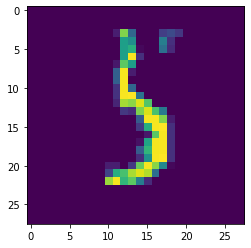

In [ ]:
plt.imshow(img.view(1, 28, 28).squeeze())
ps

In [ ]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9739


In [ ]:
t.dtype
t.device

device(type='cpu')

In [ ]:
device = torch.device ('cuda:0')
device

device(type='cuda', index=0)

In [ ]:
#Another NN'
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

# 1. Build a computation graph
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 1)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output
net = Net()


In [ ]:
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=10, bias=True)
)


In [ ]:
for param in net.parameters():
  print(param.shape)

torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([10, 1024])
torch.Size([10])


In [ ]:
optimizer = optim.Adadelta(net.parameters(), lr=1.)  # 2. Setup optimizer
criterion = nn.NLLLoss()  # 3. Setup criterion

In [ ]:
transform = transforms.Compose([
    transforms.Resize((8, 8)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(
    'data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512)

In [ ]:
for inputs, target in train_loader:
    output = net(inputs)
    loss = criterion(output, target)
    print(round(loss.item(), 2))

    net.zero_grad()
    loss.backward()
    optimizer.step()

2.32
2.21
2.09
1.9
1.64
1.38
1.27
1.38
1.2
1.04
0.82
0.8
0.94
0.93
0.81
0.66
0.82
0.88
0.67
0.58
0.57
0.84
0.73
0.58
0.64
0.6
0.49
0.6
0.68
0.45
0.49
0.46
0.48
0.49
0.58
0.36
0.4
0.44
0.38
0.47
0.66
0.47
0.34
0.39
0.4
0.41
0.38
0.44
0.43
0.35
0.3
0.38
0.39
0.37
0.34
0.38
0.35
0.31
0.49
0.42
0.44
0.48
0.34
0.38
0.34
0.33
0.2
0.36
0.32
0.28
0.25
0.26
0.34
0.34
0.28
0.3
0.32
0.37
0.29
0.24
0.32
0.26
0.33
0.36
0.24
0.24
0.34
0.32
0.27
0.27
0.28
0.22
0.29
0.27
0.25
0.27
0.33
0.24
0.37
0.24
0.21
0.25
0.21
0.35
0.23
0.27
0.21
0.25
0.22
0.21
0.2
0.19
0.22
0.13
0.12
0.11
0.18
0.39


In [ ]:
val_dataset = datasets.MNIST(
    'data', train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=512)

In [ ]:
correct = 0.
net.eval()
for inputs, target in val_loader:
    output = net(inputs)
    _, pred = output.max(1)
    correct += (pred == target).sum()
accuracy = correct / len(val_dataset) * 100.
print(f'{accuracy:.2f}% correct')

88.37% correct
